In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stumbleupon/test.tsv
/kaggle/input/stumbleupon/train.tsv
/kaggle/input/stumbleupon/sampleSubmission.csv
/kaggle/input/stumbleupon/raw_content.zip


In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from nltk.stem import PorterStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# taking all columns of training set only for data exploration
df_train=pd.read_csv('../input/stumbleupon/train.tsv',sep='\t')

# taking boilerplate column as an input for the model beacuse only this column contain lot of high quality text data useful for our nlp task
df_test=pd.read_csv('../input/stumbleupon/test.tsv',sep='\t')

In [7]:
df_test.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,...,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,...,0.080000,?,1,62,0,382,39,2,0.128205,0.176471
2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",?,?,2.269565,0.495726,0.384615,0.170940,0.170940,...,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,...,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,...,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341


In [ ]:
df_train.columns

In [ ]:
df_test.shape

In [8]:
df_train=df_train.dropna()

In [9]:
df_train.reset_index(inplace=True)
df_train.shape

(7395, 28)

In [ ]:
df_train['boilerplate'][0]

In [ ]:
df_train.columns

In [107]:
varValue = df_train.label.value_counts()
print(varValue)

1    3796
0    3599
Name: label, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

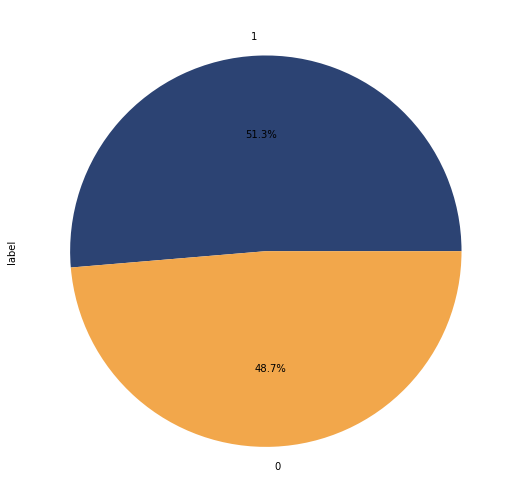

In [10]:
df_train['label'].value_counts().plot(kind='pie',colors=['#2C4373', '#F2A74B'],autopct='%1.1f%%',figsize=(9,9))
plt.show

In [11]:
df_train['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

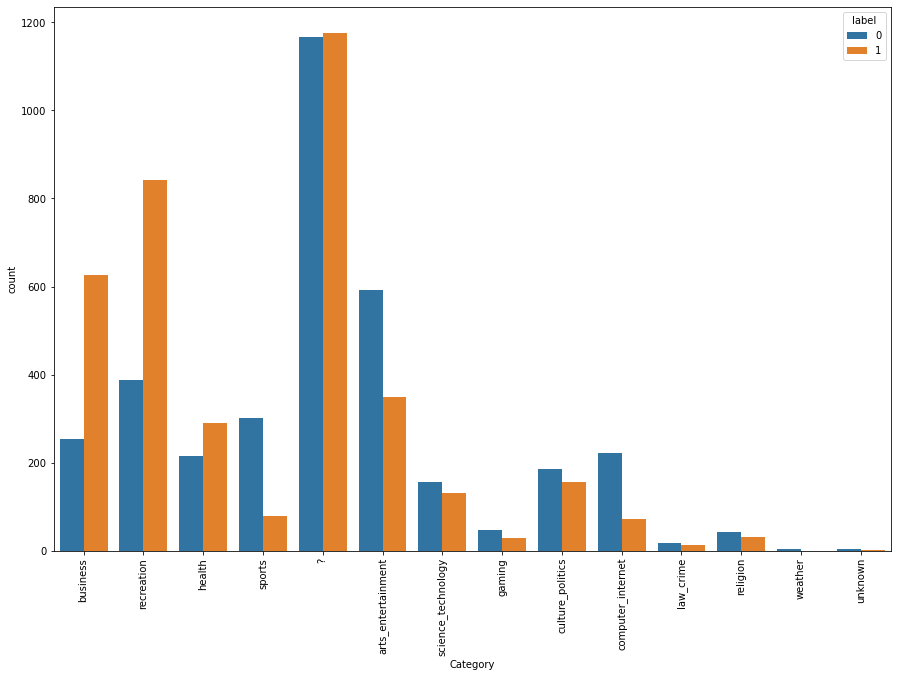

In [12]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

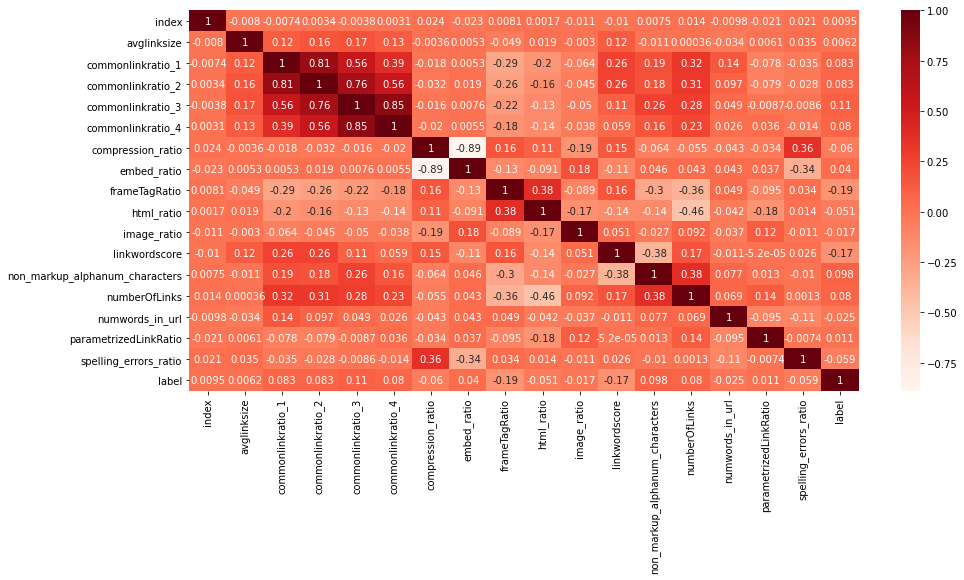

In [13]:
x_data=df_train.drop(['url', 'urlid', 'boilerplate','alchemy_category','framebased','hasDomainLink','is_news','lengthyLinkDomain','news_front_page'],axis=1)

X = x_data.drop("label",1)
y = x_data["label"]
x_data.head()
plt.figure(figsize=(15,7))
cor = x_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["label"]) #absolute value

In [14]:
relevant_features = cor_target[cor_target>=0.1]

In [15]:
import json

title=[]
body=[]
label=[]
alchemy_category_score=[]
urlid=[]
url=[]
linkwordscore=[]
frameTagRatio =[]
commonlinkratio_3    =[]
for i in range(7395):
    X=json.loads(df_train["boilerplate"][i])
    if 'title' in X.keys() and 'body' in X.keys() and 'url' in X.keys():
        title.append(X.get('title'))
        body.append(X.get('body'))
        url.append(X.get('url'))
        label.append(df_train['label'][i])
        alchemy_category_score.append(df_train['alchemy_category_score'][i])
        urlid.append(df_train['urlid'][i])
        linkwordscore.append(df_train['linkwordscore'][i])
        frameTagRatio.append(df_train['frameTagRatio'][i])
        commonlinkratio_3.append(df_train['commonlinkratio_3'][i])
    

dict_df = {'urlid':urlid,'title':title,'body':body,'url':url,'linkwordscore':linkwordscore,'frameTagRatio':frameTagRatio,'alchemy_category_score':alchemy_category_score,'commonlinkratio_3':commonlinkratio_3,'label':label}
data_df = pd.DataFrame.from_dict(dict_df)



In [16]:
data_df.columns

Index(['urlid', 'title', 'body', 'url', 'linkwordscore', 'frameTagRatio',
       'alchemy_category_score', 'commonlinkratio_3', 'label'],
      dtype='object')

In [18]:
data_df['body'].isnull().value_counts()

False    7278
True       57
Name: body, dtype: int64

In [111]:
data_df=data_df.dropna()
data_df.reset_index(inplace=True,drop=True)

In [11]:
data_df['body'].isnull().value_counts()

False    7267
Name: body, dtype: int64

In [19]:
import json

title=[]
body=[]
alchemy_category_score=[]
urlid=[]
url=[]
linkwordscore=[]
frameTagRatio =[]
commonlinkratio_3    =[]

for i in range(len(df_test)):
    X=json.loads(df_test["boilerplate"][i])
    if 'title' in X.keys() and 'body' in X.keys() and 'url'in X.keys():
        title.append(X.get('title'))
        body.append(X.get('body'))
        url.append(X.get('url'))
        alchemy_category_score.append(df_test['alchemy_category_score'][i])
        urlid.append(df_test['urlid'][i])
        linkwordscore.append(df_test['linkwordscore'][i])
        frameTagRatio.append(df_test['frameTagRatio'][i])
        commonlinkratio_3.append(df_test['commonlinkratio_3'][i])

dict_df = {'urlid':urlid,'title':title,'body':body,'url':url,'linkwordscore':linkwordscore,'frameTagRatio':frameTagRatio,'alchemy_category_score':alchemy_category_score,'commonlinkratio_3':commonlinkratio_3}
test_df = pd.DataFrame.from_dict(dict_df)

test_df=test_df.dropna()
test_df.reset_index(inplace=True)

In [ ]:
test_df.shape

In [20]:
X=data_df.drop('label',axis=1).values### independent features
y=data_df['label'].values###dependent features

In [ ]:
data_df.columns

In [ ]:
data_df['alchemy_category_score'].dtype

In [21]:

import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(data_df)):
    
    content = re.sub('[^a-zA-Z]', ' ', data_df['title'][i])
    content = content.lower()
    content = content.split()
    
    content = [ps.stem(word) for word in content if not word in stopwords.words('english')]
    content = ' '.join(content)
    corpus.append(content)
print('end')

TypeError: expected string or bytes-like object

In [60]:
data_df['title'][0]

'IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries'

In [95]:
corpus



['ibm see holograph call air breath batteri ibm see holograph call air breath batteri',
 'fulli electron futurist start gun elimin advantag race fulli electron futurist start gun elimin advantag race fulli electron futurist start gun elimin advantag race',
 'fruit fight flu fruit fight flu cold flu men health',
 'foolproof tip better sleep',
 'coolest jersey know exist coolest jersey seen',
 'genit herp treatment',
 'fashion lane american wild child',
 'race recoveri dean johnson race recoveri dean johnson insidershealth com',
 'valet handbook day day',
 'cooki cream browni sweet',
 'busi financi news break us intern news',
 'tip cap greatest iron man',
 'food trash teeth',
 '',
 'french onion steak red wine sauc french onion steak red wine sauc',
 'izabel goulart swimsuit kikidol sport illustr swimsuit photo galleri izabel goulart model sport illustr swimsuit edit si com izabel goulart si swimsuit',
 'liquid mountain awesom',
 'grill peach sugarcraft',
 'make home healthier room room 

In [92]:
len(corpus)

7267

In [117]:
vocabulary = set()
for corpu in corpus:
        if corpu not in vocabulary:
            vocabulary.add(corpu)

In [118]:
vocab_length = len(vocabulary)

In [119]:
max_seq_length = 0

for title in corpus:
    if len(title) > max_seq_length:
        max_seq_length = len(title)


In [120]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 6693
Max sequence length: 275


In [121]:
onehot_repr=[one_hot(words,vocab_length)for words in corpus] 

In [196]:

embedded_docs = pad_sequences(onehot_repr, maxlen=74)

In [198]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  655, 1812, 1273, 3137, 2333, 5712,
       5119,  655, 1812, 1273, 3137, 2333, 5712, 5119], dtype=int32)

In [199]:

embedding_dim=80


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(embedded_docs)

In [200]:
lstm_out=LSTM(units=60)(embedding)

In [201]:
lstm_out= lstm_out.numpy()
type(lstm_out)

numpy.ndarray

In [150]:
for i in range(0,data_df.shape[0]):
    if(data_df['alchemy_category_score'][i] == '?'):
        data_df['alchemy_category_score'][i]= '0'
        
data_df['alchemy_category_score'] = data_df['alchemy_category_score'].astype(float)

In [151]:
mean1=0;
mean2=0;
c1=0;
c2=0;
for i in range(0,len(data_df['alchemy_category_score'])):
    if(data_df['label'][i]==0):
        mean1=mean1+data_df['alchemy_category_score'][i]
        c1=c1+1
    if(data_df['label'][i]==1):
        mean2=mean2+data_df['alchemy_category_score'][i]
        c2=c2+1
mean2=mean2/c2
mean1=mean1/c1
    

In [152]:
for i in range(0,len(data_df['alchemy_category_score'])):
    if(data_df['alchemy_category_score'][i]==0 &data_df['label'][i]==0):
        data_df['alchemy_category_score'][i]=mean1
    if(data_df['alchemy_category_score'][i]==0 &data_df['label'][i]==1):
         data_df['alchemy_category_score'][i]=mean2

In [ ]:
data_df.columns

In [202]:
temp1 = np.array(data_df['alchemy_category_score'].values.tolist())
print("shape before = ",temp1.shape)
temp1 = np.reshape(temp1,(-1,1))
print("shape after = ",temp1.shape)

temp2= np.array(data_df['linkwordscore'].values.tolist())
temp2 = np.reshape(temp2,(-1,1))

temp3= np.array(data_df['frameTagRatio'].values.tolist())
temp3 = np.reshape(temp3,(-1,1))


temp4= np.array(data_df['commonlinkratio_3'].values.tolist())
temp4 = np.reshape(temp4,(-1,1))

print("lstm_out shape before = ",lstm_out.shape)
lstm_out = np.concatenate([lstm_out,temp3,temp2,temp4], 1)
print("lstm_out shape after = ",lstm_out.shape)

shape before =  (7267,)
shape after =  (7267, 1)
lstm_out shape before =  (7267, 60)
lstm_out shape after =  (7267, 63)


In [203]:
y_final=np.array(y)

In [2]:

X_train,X_test,y_train,y_test=train_test_split(lstm_out,y_final,test_size=0.25,random_state=0)

X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

## Modelwith Pytorch

class ANN_Model(nn.Module):
    def __init__(self,input_features=63,hidden1=70,hidden2=60,hidden3=40,hidden4=30,hidden5=20,out_features=2):
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1,hidden2)
        self.f_connected3=nn.Linear(hidden2,hidden3)
        self.f_connected4=nn.Linear(hidden3,hidden4)
        self.f_connected5=nn.Linear(hidden4,hidden4)
        self.f_connected6=nn.Linear(hidden4,hidden4)
        self.f_connected7=nn.Linear(hidden4,hidden4)
        self.f_connected8=nn.Linear(hidden4,hidden4)
        self.f_connected9=nn.Linear(hidden4,hidden5)
     
     
     
        self.out=nn.Linear(hidden5,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=F.relu(self.f_connected3(x))
        x=F.relu(self.f_connected4(x))
        x=F.relu(self.f_connected5(x))
        x=F.relu(self.f_connected6(x))
        x=F.relu(self.f_connected7(x))
        x=F.relu(self.f_connected8(x))
        x=F.relu(self.f_connected9(x))
        x=self.out(x)
        return x
###

NameError: name 'train_test_split' is not defined

In [239]:
torch.manual_seed(20)
model=ANN_Model()
model.parameters
## BACKWORD PROGAGATION
loss_function=nn.CrossEntropyLoss()
otimizer=torch.optim.Adam(model.parameters(),lr=.03)

In [ ]:

from sklearn.metrics import accuracy_score
import time
start_time=time.time()
epochs=1000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    otimizer.zero_grad()
    loss.backward()
    otimizer.step()
print(time.time()-start_time)

Epoch number: 1 and the loss : 0.6939560174942017
Epoch number: 11 and the loss : 0.6971752047538757
Epoch number: 21 and the loss : 0.6928166747093201
Epoch number: 31 and the loss : 0.6934349536895752
Epoch number: 41 and the loss : 0.6929777264595032
Epoch number: 51 and the loss : 0.6929779052734375
Epoch number: 61 and the loss : 0.69297194480896
Epoch number: 71 and the loss : 0.6929445266723633
Epoch number: 81 and the loss : 0.6929283142089844
Epoch number: 91 and the loss : 0.6921077966690063
Epoch number: 101 and the loss : 0.6909481883049011
Epoch number: 111 and the loss : 0.6919575333595276
Epoch number: 121 and the loss : 0.6913189888000488
Epoch number: 131 and the loss : 0.6924476623535156
Epoch number: 141 and the loss : 0.6913437843322754
Epoch number: 151 and the loss : 0.6913039088249207
Epoch number: 161 and the loss : 0.6912789344787598
Epoch number: 171 and the loss : 0.6912497282028198
Epoch number: 181 and the loss : 0.6912661790847778
Epoch number: 191 and the

0
1
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
1
0
1
1
1
1
1
0
1
1
1
0
1
1
0
1
1
0
1
0
0
0
0
0
1
0
1
1
0
0
0
0
1
0
1
0
0
0
1
1
0
1
0
0
0
1
0
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
1
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
1
1
1
0
0
1
0
0
0
1
0
0
0
1
0
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
1
0
1
1
0
1
0
1
0
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
1
0
1
1
0
1
0
0
0
1
1
0
1
0
0
0
0
0
1
0
1
1
0
0
1
1
0
0
1
0
1
0
0
1
1
1
1
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
1
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
0
0
1
1
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
1
0
0
1
0
0
1
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
1
1
0
1
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
0
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
1
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
1
1
0
1
0
0
1
1
1
0
1
0
1
1
1
0
0
1
1
0
0
1
0
1
0
0
0
1
1
1
1
0
1
0
1
0
0
1
0
0
0
0
0
1
0
0
1
1
0
0
0
1
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0


Text(69.0, 0.5, 'Predicted Values')

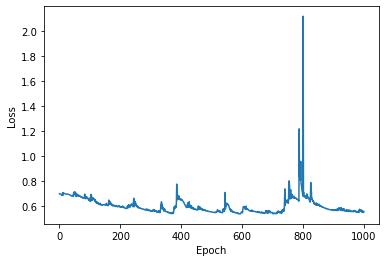

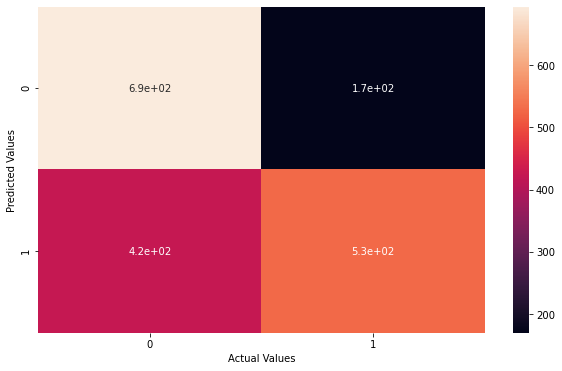

In [232]:
## loss function
import matplotlib.pyplot as plt

plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
#### Prediction in X_test data
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=model(data)
        predictions.append(y_pred.argmax().item())
        print(y_pred.argmax().item())

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,predictions)
cm
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [233]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[694, 170],
       [424, 529]])

In [234]:

from sklearn.metrics import accuracy_score

accuracy_score(y_test,predictions)

0.6730875068794716

In [235]:
from sklearn.metrics import recall_score
recall_score(y_test,predictions)

0.5550891920251836

In [236]:
from sklearn.metrics import precision_score
precision_score(y_test,predictions)

0.7567954220314735

In [ ]:
#prediction of test dataset
ps=PorterStemmer()
def process_title(title):
    new_title = title.lower()
    new_title = re.sub(r'\$[^\s]+', 'dollar', new_title)
    new_title = re.sub(r'[^a-z0-9\s]', '', new_title)
    new_title = re.sub(r'[0-9]+', 'number', new_title)
    new_title = new_title.split(" ")
    new_title = list(map(lambda x: ps.stem(x), new_title))
    new_title = list(map(lambda x: x.strip(), new_title))
    if '' in new_title:
        new_title.remove('')
    return new_title
titles = df_test['title'].apply(process_title)


In [ ]:
max_seq_length = 0

for title in titles:
    if len(title) > max_seq_length:
        max_seq_length = len(title)
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(titles)

sequences = tokenizer.texts_to_sequences(titles)
embedded_docs = pad_sequences(sequences, maxlen=max_seq_length)
embedding_dim = 80


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(embedded_docs)
lstm_out=LSTM(units=60)(embedding)
lstm_out= lstm_out.numpy()

temp1 = np.array(data_df['alchemy_category_score'].values.tolist())

temp1 = np.reshape(temp1,(-1,1))


temp2= np.array(data_df['linkwordscore'].values.tolist())
temp2 = np.reshape(temp2,(-1,1))

temp3= np.array(data_df['frameTagRatio'].values.tolist())
temp3 = np.reshape(temp3,(-1,1))


temp4= np.array(data_df['commonlinkratio_3'].values.tolist())
temp4 = np.reshape(temp4,(-1,1))


lstm_out2 = np.concatenate([lstm_out,temp3,temp2,temp4], 1)


In [ ]:
  y_pred=model.forward(X_train)